<a href="https://colab.research.google.com/github/ThanosApostolou/aics-pattern-recognition/blob/main/IMDB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard
# Import tensorflow
import tensorflow as tf
import datetime, os
from google.colab import drive
drive.mount('/content/drive/')

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
Mounted at /content/drive/


In [ ]:
import numpy as np 
import pandas as pd
import os
import matplotlib.pyplot as plt
##MAIN PROGRAM VARIABLES##
##(0): dataset: np array of strings
##(1): dataframe: original dataset in its primal form
##(2): ratings_num_df: new dataframe storing the number of rated items per unique user
##(3): ratings_span_df: new dataframe storing the timespan in days for each user
##(4): minimum_ratings - maximum_ratings => ratings_df=> (i) final_df

In [ ]:
dataset = np.load('/content/drive/My Drive/Colab Notebooks/Dataset.npy')

In [ ]:
#Define the figures path
FIGURES_PATH = "figures"
os.makedirs(FIGURES_PATH, exist_ok=True)
# #Define the data folder path
DATAFOLDER_PATH = "datafile"
os.makedirs(DATAFOLDER_PATH, exist_ok=True)
#Load the dataset in an np array
#datafile = "datafile/Dataset.npy"
#dataset=np.load(dataset)

In [ ]:
#Define the splitter lambda function in order to tokenize the initial string data.
splitter = lambda s: s.split(",")
#Apply the splitter lambda function on the string np array
dataset = np.array([splitter(x) for x in dataset])
#Set the pickle file for storing the initial dataframe
pickle_file = os.path.join(DATAFOLDER_PATH, "dataframe.pkl")
#Check the existence of the specified file.
if os.path.exists(pickle_file):
    #Load the pickle file
    dataframe = pd.read_pickle(pickle_file)
else:
    #Create the dataframe object.
    dataframe = pd.DataFrame(dataset, columns=['User','Movie','Rating','Date'])
    #Convert the string elements of the "Users" series into integers
    dataframe["User"] = dataframe["User"].apply(lambda s:np.int64(s.replace("ur","")))
    #Convert the string elements of the "Movies" series into integers
    dataframe["Movie"] = dataframe["Movie"].apply(lambda s:np.int64(s.replace("tt","")))
    #Convert the string elements of the "Ratings" series into integers
    dataframe["Rating"] = dataframe["Rating"].apply(lambda s:np.int64(s))
    #Convert the string element of "Dates" series into datetime Object
    dataframe["Date"] = pd.to_datetime(dataframe["Date"])
    dataframe.to_pickle(pickle_file)

In [ ]:
#Get the unique users in the dataset.
users = dataframe["User"].unique()
#Get the number of unique users
users_num = len(users)
#Get the unique movie items in the dataset.
movies = dataframe["Movie"].unique()
#Get the number of unique movies
movies_num = len(movies)
#Get the total number of existing ratings.
ratings_num = dataframe.shape[0]
#Report the number of unique Users and Movies in the dataset
print("INITIAL DATASET: {0} number of unique users and {1} of unique movies".format(users_num, movies_num))
#Report the total number of existing ratings in the dataset
print("INITIAL DATASET: {} total number of existing ratings".format(ratings_num))

INITIAL DATASET: 1499238 number of unique users and 351109 of unique movies
INITIAL DATASET: 4669820 total number of existing ratings


In [ ]:
#Define the pickle file that will store the time span per user dataframe
pickle_file = os.path.join(DATAFOLDER_PATH, "ratings_num_df.pkl")
#Check the existence of the previously defined pickle file
if os.path.exists(pickle_file):
    #Load the pickle file
    ratings_num_df = pd.read_pickle(pickle_file)
else:
    ratings_num_df = dataframe.groupby("User")["Rating"].count().sort_values(ascending=False).reset_index(name="ratings_num")
    #Save the previously created dataframe to pickle
    ratings_num_df.to_pickle(pickle_file)

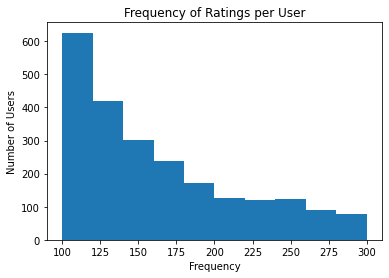

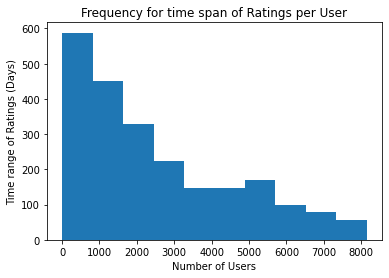

In [ ]:
#Set the pickle file that will store the time span per user dataframe
pickle_file = os.path.join(DATAFOLDER_PATH, "ratings_span_df.pkl")
if os.path.exists(pickle_file):
    ratings_span_df = pd.read_pickle(pickle_file)
else:
    ratings_span_df = dataframe.groupby("User")["Date"].apply(lambda date: max(date)-min(date)).sort_values(ascending=False).reset_index(name="ratings_span")
    ratings_span_df.to_pickle(pickle_file)
#Create a new ratings dataframe by joining the previously defined dataframe
ratings_df = ratings_num_df.join(ratings_span_df.set_index("User"),on="User")
ratings_df["ratings_span"]=ratings_df["ratings_span"].dt.days
#Set the threshold values for the minimum and maximum number of Ratings per user
minimum_ratings = 100
maximum_ratings = 300
#Discard all users that do not pertain to the previous range of ratings
reduced_ratings_df = ratings_df.loc[(ratings_df["ratings_num"] >= minimum_ratings) & (ratings_df["ratings_num"] <= maximum_ratings)]

#Generate the frequency histogram for the number of ratings per user
reduced_ratings_df["ratings_num"].plot(kind='hist', title='Frequency of Ratings per User', xticks=range(minimum_ratings, maximum_ratings+1, 25))
plt.xlabel('Frequency')
plt.ylabel('Number of Users')

plt.show()
#Generate the frequency histogram for the time span of ratings per user
reduced_ratings_df["ratings_span"].plot(kind='hist', title='Frequency for time span of Ratings per User')
plt.xlabel('Number of Users')
plt.ylabel('Time range of Ratings (Days)')

plt.show()



                                                                                    

In [ ]:
#Get the final dataframe by excluding all users whose ratings fall outside the prespecified range
final_df = dataframe.loc[dataframe["User"].isin(reduced_ratings_df["User"])].reset_index()
#Drop the links (indices) to the original table
final_df = final_df.drop("index", axis=1)
#Get the unique users and items in the final dataframe along with the final number of ratings
final_users = final_df["User"].unique()
final_movies = final_df["Movie"].unique()
final_users_num = len(final_users)
final_movies_num = len(final_movies)
final_ratings_num = len(final_df)

#Report the final number of unique users and movies in the dataset
print("REDUCED DATASET: {0} number of unique users and {1} number of unique movies".format(final_users_num, final_movies_num))
#Report the final number of existing ratings in the dataset
print("REDUCED DATASET: {} number of existing ratings in the dataset".format(final_ratings_num))

REDUCED DATASET: 2292 number of unique users and 91949 number of unique movies
REDUCED DATASET: 370860 number of existing ratings in the dataset


In [ ]:
#We need to reset the users and items IDs in order to be able to construct a network of users and Movies. 
#Users and Movies IDs should be consecutive in the [1..final_users_num] and [1...final_movies_num]
#Initially, we need to acquire the sorted versions of the user and movies
sorted_final_users = np.sort(final_users)
sorted_final_movies = np.sort(final_movies)
#Generate the dictionary of final users as a mapping of the following 
#sorted_final_users --> [0...final_users_num-1]
final_users_dict = dict(zip(sorted_final_users,list(range(0,final_users_num))))
#Generate the dictionary of final items as a mapping of the following
final_movies_dict = dict(zip(sorted_final_movies,list(range(0,final_movies_num))))
#Apply the previously defined dictionary-based maps on the users and movies columns of the final dataframe
final_df["User"] = final_df["User"].map(final_users_dict)
final_df["Movie"] = final_df["Movie"].map(final_movies_dict)
#Get a grouped version of the original dataframe based on the unique final users
users_group_df = final_df.groupby("User")
#Initialize the adjacency matrix which stores the connection status for pair of users in the recommendation network
W = np.zeros((final_users_num, final_users_num))
#Iinitialize the matrix storing the number of commonly rated items for a pair of users
CommonRatings = np.zeros((final_users_num, final_users_num))
#Initialize the matrix of common ratings
#Matrix W will be of size [final_users_num x final_users_num],
#Let U = {u1, u2,...,un} be the final set of users and I = {i1,i2,...,im}
#final set of movies. By considering the function Fi: U -> P(I) where
#P(I) is the powerset of I, Fi(u) returns the subset of items that has been rated by user u. 
#In this context, the edge weight between any given pair of users (u,v) will be computed as:
#
#          |Intersection(Fi(u)),Fi(v))|
#W(u,v) =  -----------------------------
#               |Union(Fi(u),Fi(v))|
#
#
#In order to speed up the construction of the adjacency matrix for the ratings network, 
#construct a dictionary object that will store a set of rated items for each unique user.
user_items_dict = {}
# for user in final_users:
    #print(user)
    # user_index = final_users_dict[user]
    # user_movies = set(users_group_df.get_group(user_index)["Movie"])
    # user_items_dict[user_index] = user_movies
                                                 
# Initialize the dictionary for storing the set of rated items for each user
user_items_dict = {}
# print(final_users_dict)
# print(sorted_final_users)
# print(final_users_dict)
# For each unique user, find the set of movies that they rated
for user in final_users:
    if user in final_users_dict:
        user_index = final_users_dict[user]
        user_movies = set(users_group_df.get_group(user_index)["Movie"])
        user_items_dict[user_index] = user_movies 

In [ ]:
user_ids = list(user_items_dict.keys())
user_ids.sort()
#Generate the sorted version of the dictionary
user_items_dict = {user_index:user_items_dict[user_index] for user_index in user_ids}
#Set the pickle file that will store the graph adjacency matrix W.
pickle_file_weights = os.path.join(DATAFOLDER_PATH, "w")
pickle_file_common_ratings = os.path.join(DATAFOLDER_PATH, "common_ratings")
#Check the existence of the previously defined pickle file
if os.path.exists(pickle_file_weights) & os.path.exists(pickle_file_common_ratings):
    #Load the pickle file
    W = np.load(pickle_file_weights)
    CommonRatings = np.load(pickle_file_common_ratings)
else:
    for source_user in user_items_dict.keys():
        for target_user in user_items_dict.keys():
            intersection_items = user_items_dict[source_user].intersection(user_items_dict[target_user])
            union_items = user_items_dict[source_user].union(user_items_dict[target_user])
            W[source_user, target_user] = len(intersection_items)/len(union_items)
            CommonRatings[source_user, target_user] = len(intersection_items)
    np.save(pickle_file_weights,W)
    np.save(pickle_file_common_ratings,CommonRatings)

In [ ]:
W

array([[1.        , 0.00257732, 0.        , ..., 0.00998004, 0.02122016,
        0.00481928],
       [0.00257732, 1.        , 0.        , ..., 0.        , 0.00492611,
        0.        ],
       [0.        , 0.        , 1.        , ..., 0.        , 0.        ,
        0.00414938],
       ...,
       [0.00998004, 0.        , 0.        , ..., 1.        , 0.00626959,
        0.        ],
       [0.02122016, 0.00492611, 0.        , ..., 0.00626959, 1.        ,
        0.        ],
       [0.00481928, 0.        , 0.00414938, ..., 0.        , 0.        ,
        1.        ]])

In [ ]:
CommonRatings

array([[285.,   1.,   0., ...,   5.,   8.,   2.],
       [  1., 104.,   0., ...,   0.,   1.,   0.],
       [  0.,   0., 110., ...,   0.,   0.,   1.],
       ...,
       [  5.,   0.,   0., ..., 221.,   2.,   0.],
       [  8.,   1.,   0., ...,   2., 100.,   0.],
       [  2.,   0.,   1., ...,   0.,   0., 132.]])

In [ ]:
final_df

,User,Movie,Rating,Date
0,674,14589,10,2005-01-16
1,558,25059,8,2005-01-16
2,366,33517,6,2005-01-16
3,616,37484,10,2005-01-16
4,450,8762,2,2005-01-16
...,...,...,...,...
370855,572,37373,6,2005-01-15
370856,29,35124,7,2005-01-16
370857,495,22042,6,2005-01-16
370858,29,34937,9,2005-01-16


#Δημιουργούμε έναν πίνακα χρηστών - ταινιών 
(οι χρήστες βρίσκονται στις γραμμές και οι ταινίες στις στήλες του πίνακα)
όπου τα στοιχεία του πίνακα είναι από 1 - 10. Εάν ο χρήστης δεν έχει αξιολογήσει την ταινία,
η αξιολόγηση που θα ανατεθεί είναι 0.

In [ ]:
# Create a pivot table of user-movie ratings
ratings_matrix = final_df.pivot_table(index='User', columns='Movie', values='Rating')
ratings_matrix = ratings_matrix.fillna(0)

In [ ]:
ratings_matrix

Movie,0,1,2,3,4,5,6,7,8,9,...,91939,91940,91941,91942,91943,91944,91945,91946,91947,91948
User,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2287,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2288,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2289,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
!pip install pyclustering
from pyclustering.cluster.kmeans import kmeans, kmeans_visualizer
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer
from pyclustering.samples.definitions import FCPS_SAMPLES
from pyclustering.utils import read_sample
from pyclustering.cluster.kmeans import kmeans
from pyclustering.utils.metric import type_metric, distance_metric

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 23.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyclustering: filename=pyclustering-0.10.1.2-py3-none-any.whl size=2395121 sha256=055e8d0b943865fa2bc54c25a39de06808e121dfbaf0ed95f6ddff44869f8353
  Stored in directory: /root/.cache/pip/wheels/dc/25/8b/072b221a5cff4f04e7999d39ca1b6cb5dad702cc3e1da951d4
Successfully built pyclustering


Θέλουμε να δημιουργήσουμε τον πίνακα βαρών "λ" των χρηστών. Τον πίνακα αξιολογήσεων δηλαδή όπου η τιμή της αξιολόγησης είναι 1 εάν η ταινία έχει αξιολογηθεί από τον χρήστη ή 0 εάν δεν έχει αξιολογηθεί

In [ ]:
# Threshold
threshold = 1

# Transform to binary
binary_matrix = np.where(ratings_matrix >= threshold, 1, 0)

In [ ]:
binary_matrix

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [ ]:
# Convert the matrix to a numpy array
matrix_array = ratings_matrix.to_numpy()

# Create a dictionary that maps each row of the matrix to its index
# matrix_dict = {tuple(row): i for i, row in enumerate(matrix_array)}

# ***Αλγόριθμοι Ομαδοποίησης Δεδομένων***

**Χρήση της Weighted Euclidean Distance**

In [ ]:
from scipy.spatial.distance import pdist, cdist
import numpy as np

from scipy.sparse import csr_matrix

def pairwise_weighted_euclidean_distance(X, weights):
    # Find the indices of the rated movies for each pair of users
    rated_movies = (weights_sparse.T @ weights_sparse) > 0

    # Select only the rated movies for each pair of users
    X_rated = X_sparse[:, rated_movies]
    
    # Calculate the pairwise weighted Euclidean distance between 
    #users who have rated the same movie
    return cdist(X, metric='euclidean')

def kmeans_pairwise_weighted_euclidean(X, weights, k, max_iters=2):

    n, m = X.shape
    centroids = X[np.random.choice(n, k, replace=False)]
    distances = pairwise_weighted_euclidean_distance(X, weights)
    for i in range(max_iters):
        # Assign points to clusters
        cluster_assignments = np.argmin(distances, axis=1)

        # Recalculate cluster centroids
        for j in range(k):
            cluster_points = X[cluster_assignments == j]
            if len(cluster_points) > 0:
                centroids[j] = np.average(cluster_points, axis=0)

        # Update distances to centroids
        distances = pairwise_weighted_euclidean_distance(X, weights)

    return cluster_assignments, centroids


In [ ]:
# Calculate the weighted Euclidean distance matrix
D = np.zeros((ratings_matrix.shape[0], ratings_matrix.shape[0]))

for i in range(ratings_matrix.shape[0]):
    for j in range(i, ratings_matrix.shape[0]):
        d = np.sqrt(np.sum(binary_matrix[i,:]*binary_matrix[j,:] * (ratings_matrix.iloc[i,:] - ratings_matrix.iloc[j,:])**2))
        D[i,j] = d
        D[j,i] = d


In [ ]:
D

# Clustering users using K-means
 We want to start by creating the symmetric D matrix which contains the pairwise weighted Euclidean distance for every pair of users.
 We calculate the distance between each user using 
*   dist_{u,v}=\sum_{k=1}^{n}\sqrt{|R_{u}(k) - R_{v}(k)|λ_{u}(k)λ_{v}(k)}




In [ ]:
# Calculate the pairwise weighted Euclidean distance matrix
n = ratings_matrix.shape[0]
n = 100
Dist_euclidean = np.zeros((n, n))
for i in range(n):
  for j in range(i, n):
      d = np.sqrt(np.sum(binary_matrix[i,:] * binary_matrix[j,:] * (ratings_matrix.loc[i,:] - ratings_matrix.loc[j,:])**2))
      Dist_euclidean[i,j] = d
      Dist_euclidean[j,i] = d

In [ ]:
df_euclidean = pd.DataFrame(Dist_euclidean)
df_euclidean

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.000000,1.000000,0.000000,3.464102,1.000000,3.872983,2.236068,5.000000,3.162278,9.000000,...,5.830952,3.162278,7.141428,2.000000,0.000000,2.000000,1.000000,0.000000,0.000000,1.414214
1,1.000000,0.000000,0.000000,0.000000,2.236068,7.211103,9.380832,4.000000,4.242641,7.000000,...,0.000000,3.000000,8.306624,0.000000,1.000000,2.000000,9.273618,1.732051,11.445523,7.348469
2,0.000000,0.000000,0.000000,0.000000,18.520259,10.099505,5.099020,0.000000,0.000000,8.544004,...,0.000000,9.000000,13.784049,6.708204,0.000000,2.000000,4.000000,6.000000,11.000000,7.348469
3,3.464102,0.000000,0.000000,0.000000,7.071068,2.236068,2.000000,3.605551,2.828427,2.449490,...,0.000000,8.062258,8.306624,2.000000,3.464102,1.000000,4.242641,3.605551,2.236068,3.741657
4,1.000000,2.236068,18.520259,7.071068,0.000000,13.266499,9.486833,1.414214,8.246211,6.164414,...,8.000000,11.618950,10.344080,0.000000,0.000000,5.000000,0.000000,4.690416,9.591663,9.695360
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,2.000000,2.000000,2.000000,1.000000,5.000000,0.000000,6.633250,0.000000,0.000000,6.164414,...,5.830952,0.000000,8.485281,4.000000,0.000000,0.000000,0.000000,0.000000,5.830952,3.464102
96,1.000000,9.273618,4.000000,4.242641,0.000000,4.242641,0.000000,6.480741,5.477226,5.099020,...,0.000000,0.000000,4.358899,5.000000,0.000000,0.000000,0.000000,5.385165,3.000000,0.000000
97,0.000000,1.732051,6.000000,3.605551,4.690416,3.000000,0.000000,4.123106,1.000000,0.000000,...,0.000000,5.477226,4.795832,0.000000,3.872983,0.000000,5.385165,0.000000,3.872983,2.449490
98,0.000000,11.445523,11.000000,2.236068,9.591663,8.602325,15.198684,9.433981,4.000000,6.403124,...,2.236068,12.369317,10.392305,4.000000,0.000000,5.830952,3.000000,3.872983,0.000000,3.316625


Στον πίνακα αποστάσεων που έχουμε δημιουργήσει, θα τρέξουμε τον αλγόριθμο k-means ώστε να αποτιμήσουμε την ομοιότητα των χρηστών χρησιμοποιώντας τις μεταξύ τους αποστάσεις.

In [ ]:
from sklearn.cluster import KMeans
# Cluster the users using K-means
kmeans = KMeans(n_clusters=5).fit(Dist_euclidean)

# Get the cluster labels
labels_euclidean = kmeans.labels_

# Print the labels
print(labels_euclidean)

[2 0 3 2 4 3 0 0 2 0 0 3 2 0 2 2 2 1 2 1 1 1 2 1 1 3 1 2 2 1 1 2 2 3 4 2 2
 1 2 2 2 0 1 1 0 0 2 2 2 0 2 2 2 0 0 2 0 1 4 4 4 2 2 0 1 1 3 4 2 1 0 0 0 1
 3 2 4 2 4 2 3 1 2 1 2 1 4 0 0 1 1 3 4 2 2 1 2 2 0 1]


Cluster the users, by using a custom 
dist = 1 - np.abs(np.sum(R_u*R_v*weights_u*weights_l)/(np.sqrt(R^2_u*weights_u*weights_l)*np.sqrt(R^2_v*weights_u*weights_l)

---



In [ ]:
# Calculate the pairwise weighted Cosine distance matrix
n = ratings_matrix.shape[0]
n = 100
Dist_cosine = np.zeros((n, n))
for i in range(n):
  for j in range(i, n):
      d = 1 - np.abs(np.sum(binary_matrix[i,:] * binary_matrix[j,:] * ratings_matrix.loc[i,:] * ratings_matrix.loc[j,:]) / (np.sqrt(np.sum(binary_matrix[i,:] * binary_matrix[j,:] * ratings_matrix.loc[i,:])* np.sqrt(np.sum(binary_matrix[i,:] * binary_matrix[j,:] * ratings_matrix.loc[j,:])))))
      Dist_cosine[i,j] = d
      Dist_cosine[j,i] = d

<ipython-input-25-1eb834a4b67d>:7: RuntimeWarning: invalid value encountered in double_scalars
  d = 1 - np.abs(np.sum(binary_matrix[i,:] * binary_matrix[j,:] * ratings_matrix.loc[i,:] * ratings_matrix.loc[j,:]) / (np.sqrt(np.sum(binary_matrix[i,:] * binary_matrix[j,:] * ratings_matrix.loc[i,:])* np.sqrt(np.sum(binary_matrix[i,:] * binary_matrix[j,:] * ratings_matrix.loc[j,:])))))


In [ ]:
df_cosine = pd.DataFrame(Dist_cosine)
df_cosine = df_cosine.replace(np.nan, 0)
df_cosine

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,-49.304560,-7.190363,0.000000,-23.171316,-9.142907,-18.187750,-21.390613,-16.223299,-13.966630,-15.393314,...,-23.085214,-16.078251,-21.700708,-0.732051,0.000000,-12.747727,-11.172184,0.000000,0.000000,-11.535933
1,-7.190363,-34.026614,0.000000,0.000000,-18.396831,-13.800810,-19.124894,-18.117955,-8.156362,-15.315598,...,0.000000,-13.878153,-14.364750,-12.454343,-11.172184,-4.097133,-11.055067,-14.536688,-11.497541,-9.073867
2,0.000000,0.000000,-23.231996,0.000000,-7.585784,-4.922172,-13.478446,0.000000,0.000000,-12.378077,...,0.000000,-3.270999,-12.213968,-5.794772,0.000000,-9.843224,-2.343702,-3.303517,-6.020827,-11.943213
3,-23.171316,0.000000,0.000000,-45.588603,-10.246827,-15.527989,-11.910551,-13.895640,-18.621917,-21.414019,...,0.000000,-10.022704,-25.045582,-10.651803,-18.078541,-8.494928,-10.246827,-13.015599,-12.142775,-16.943015
4,-9.142907,-18.396831,-7.585784,-10.246827,-51.417993,-15.439397,-26.476203,-15.500000,-13.500979,-21.888741,...,-14.762526,-20.173401,-26.733711,0.000000,0.000000,-18.302907,0.000000,-21.231116,-24.863647,-26.508677
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,-12.747727,-4.097133,-9.843224,-8.494928,-18.302907,0.000000,-12.125509,0.000000,0.000000,-18.734868,...,-19.818206,0.000000,-9.989856,-4.421612,0.000000,-30.240455,0.000000,0.000000,-14.831682,-14.699527
96,-11.172184,-11.055067,-2.343702,-10.246827,0.000000,-9.899263,0.000000,-11.906572,-17.829117,-16.492576,...,0.000000,0.000000,-14.315397,-14.308848,0.000000,0.000000,-28.887449,-11.294019,-2.760603,0.000000
97,0.000000,-14.536688,-3.303517,-13.015599,-21.231116,-11.331566,0.000000,-14.655434,-13.270485,0.000000,...,0.000000,-15.005746,-18.066086,-10.386036,-14.431785,0.000000,-11.294019,-39.770442,-16.177198,-18.417113
98,0.000000,-11.497541,-6.020827,-12.142775,-24.863647,-12.320273,-12.467404,-8.622957,-5.858527,-22.974630,...,-16.897856,-13.813876,-20.935056,-4.421612,0.000000,-14.831682,-2.760603,-16.177198,-43.221001,-18.832807


Στον πίνακα αποστάσεων που έχουμε δημιουργήσει, θα τρέξουμε τον αλγόριθμο k-means ώστε να αποτιμήσουμε την ομοιότητα των χρηστών χρησιμοποιώντας τις μεταξύ τους αποστάσεις.

In [ ]:
# Cluster the users using K-means
kmeans = KMeans(n_clusters=5).fit(df_cosine)

# Get the cluster labels
labels_cosine = kmeans.labels_

# Print the labels
print(labels_cosine)


[3 4 2 3 1 4 1 3 3 1 3 4 1 3 3 0 4 1 0 1 0 4 4 1 3 4 4 2 0 0 0 2 4 0 1 2 4
 0 3 2 4 3 0 1 1 3 3 4 2 0 2 4 2 3 3 2 3 1 1 1 1 2 2 3 1 1 2 1 4 4 3 1 3 0
 3 2 1 4 1 3 0 4 2 1 0 4 1 1 3 1 1 4 1 2 2 0 2 4 1 1]


# Elbow Method
Χρησιμοποιούμε την elbow method ώστε να επιλέξουμε τον βέλτιστο αριθμό clusters στον οποίο θα διαχωριστούν τα δεδομένα χρησιμοποιώντας τον k-means

In [ ]:
def elbow_method(df: pd.DataFrame, max_iter: int):
  distortions = []
  K = range(1,max_iter)
  for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(df)
    distortions.append(kmeanModel.inertia_)
  plt.figure(figsize=(16,8))
  plt.plot(K, distortions, 'bx-')
  plt.xlabel('k')
  plt.ylabel('Distortion')
  plt.title('The Elbow Method showing the optimal k')
  plt.show()


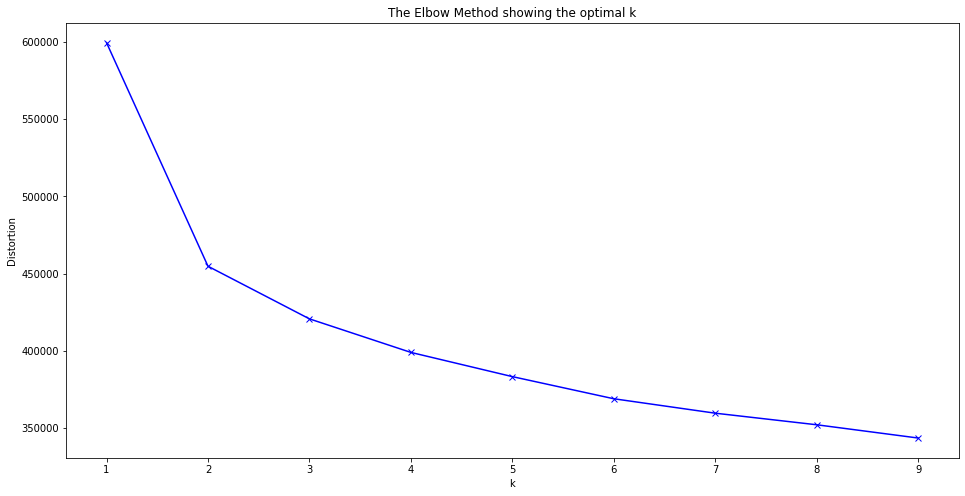

In [ ]:
#Using the elbow method on Cosine distance
elbow_method(df_cosine, 10)

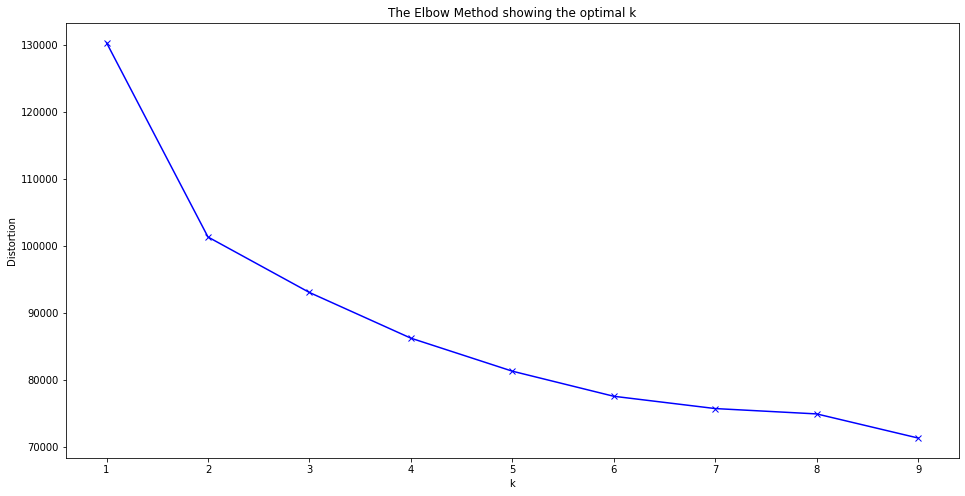

In [ ]:
#Using the elbow method on Euclidean distance
elbow_method(Dist_euclidean, 10)

First, we have to modify our df in order to keep the first n users and assign our labels to them

In [ ]:
ratings_matrix = ratings_matrix.head(100)
ratings_matrix

Movie,0,1,2,3,4,5,6,7,8,9,...,91939,91940,91941,91942,91943,91944,91945,91946,91947,91948
User,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
96,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
97,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Next, we'll use the PCA method in order to reduce the dimensionality of our matrix and plot our clusters

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# instantiate StandardScaler and PCA with 2 components for 2D scatter plot
scaler = StandardScaler()
pca = PCA(n_components=2)

# fit and transform the ratings matrix
ratings_pca = pca.fit_transform(ratings_matrix)

# print the explained variance ratio for each component
print(pca.explained_variance_ratio_)

[0.03125536 0.02106027]


In [ ]:
# create a new dataframe with the PCA components and user index
df_pca = pd.DataFrame(ratings_pca, index=range(0, 100))
df_pca['Cluster'] = labels_euclidean
df_pca

,0,1,Cluster
0,-9.435396,17.409961,2
1,-6.985136,-1.331159,0
2,-6.612541,-2.246603,3
3,-7.756736,2.176538,2
4,19.738537,2.204748,4
...,...,...,...
95,-5.372082,-3.256038,1
96,-9.031271,-2.442580,2
97,-4.364878,-4.919095,2
98,6.857017,0.346031,0


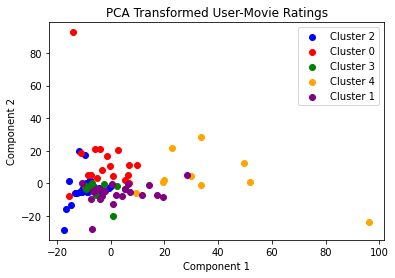

In [ ]:
# create a scatter plot of the PCA components
fig, ax = plt.subplots()

for label, color in zip(df_pca['Cluster'].unique(), ['blue', 'red', 'green', 'orange', 'purple']):
    group = df_pca.groupby('Cluster').get_group(label)
    ax.scatter(group[0], group[1], c=color, label=f'Cluster {label}')

# set the axis labels and title
ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
ax.set_title('PCA Transformed User-Movie Ratings')

# add a legend
ax.legend()

# show the plot
plt.show()